In [16]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from utils import plot_series

In [17]:
ridership = pd.read_csv("files/ridership_Daily_Boarding_Totals.csv", parse_dates=['service_date'])
ridership.columns = ['date', 'day_type', 'bus', 'rail', 'total']
ridership = ridership.sort_values(by='date').set_index("date")
ridership.drop(['total'], axis=1, inplace=True)
ridership.drop_duplicates()

ridership

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


## parameters from ARMA
###### p = how many past values we will use to calculate the next value
###### d = how many times we will difference the data
###### q = Moving Average (MA) Term - so its the size of the moving average window

## new parameters from ARIMA
###### P = Similar to the 'p' in ARIMA, but it relates to the seasonal part of the time series. It represents the number of seasonal lags of the autoregressive (AR) model. If your data has a seasonal pattern, 'P' helps the model to incorporate this by using past seasonal periods. For example, P = 1 in a monthly series with yearly seasonality would mean using the value from the same month in the previous year in the prediction.
###### D = This is similar to 'd' in ARIMA but applied to the seasonal component. It indicates the number of seasonal differences required to make the series stationary. For instance, if you have monthly data with a yearly pattern, you might need to difference the data every 12 month
###### Q = Similar to 'q' in ARIMA, 'Q' refers to the order of the seasonal moving average component. It represents the number of seasonal lagged forecast errors that the model uses when making predictions.
###### s = Seasonal Period Length: This is an additional parameter that specifies the length of the seasonal cycle. For example, in a monthly dataset with an annual cycle, S would be 12 (indicating 12 months in a year). This parameter is crucial as it defines the periodicity of the seasonal effects.


In [18]:
origin, today = '2019-01-01', '2019-05-31'
rail_series = ridership.loc[origin:today, 'rail'].asfreq('D')

model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

print('error', tf.keras.metrics.mean_absolute_error(ridership.loc['2019-06-01', 'rail'], y_pred).numpy())

y_pred

error 48714.62622130173


2019-06-01    427758.626221
Freq: D, dtype: float64

In [39]:
from typing import Tuple, List

origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'
rail_series = ridership.loc[origin:end_date, 'rail'].asfreq('D')
time_period = pd.date_range(start_date, end_date)

def predict_and_train_arima(origin, time_period, rail_series, order, seasonal_order) -> Tuple[ARIMA, List[float]]: 
    y_preds = []
    model = None
    
    for today in time_period.shift(-1):
        model = ARIMA(
            rail_series.loc[origin:today],
            order=order,
            seasonal_order=seasonal_order
        )  # we retrain the model every day
        model = model.fit()
        y_pred = model.forecast()
        y_preds.append(y_pred[0])
    
    return model, y_preds

print('error', tf.keras.metrics.mean_absolute_error(rail_series[time_period], predict_and_train_arima(origin, time_period, rail_series, (1, 0, 0), (0, 1, 1, 7))[1]).numpy())

error 32040.72008869453


In [20]:
print('real_error_last_prediction', tf.keras.metrics.mean_absolute_error(rail_series[time_period][-1], y_pred).numpy())

real_error_last_prediction 39295.476331048296


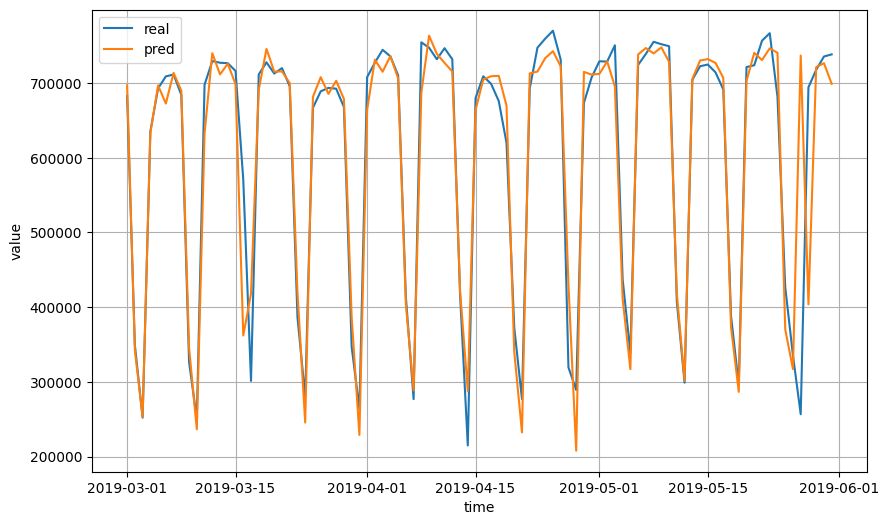

In [21]:
plot_series(rail_series[time_period].index, (rail_series[time_period], y_preds), legend_labels=['real', 'pred'])

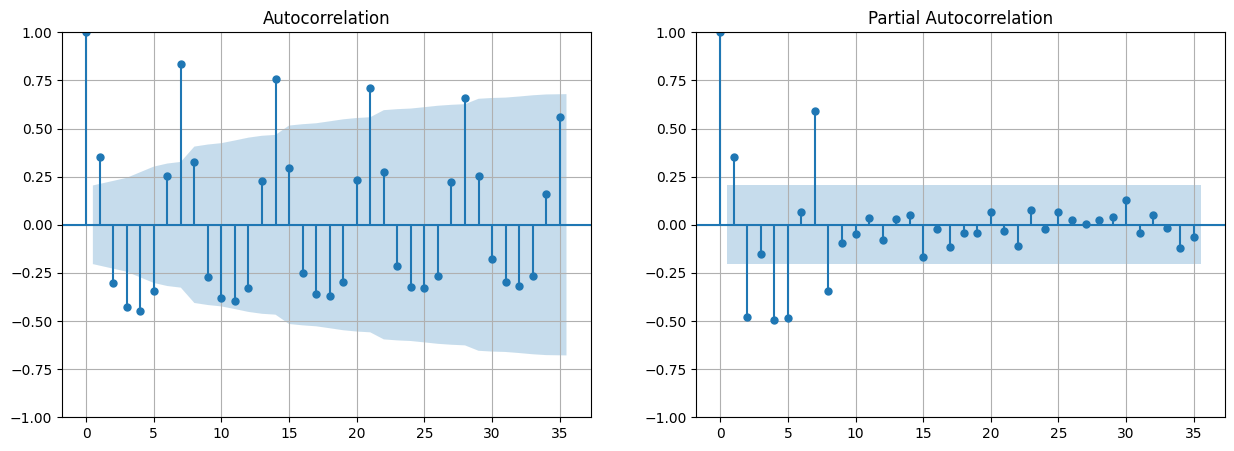

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(rail_series[time_period], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(rail_series[time_period], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [51]:
from sklearn.model_selection import GridSearchCV


order =  [(1, 0, 0), (2, 1, 2), (1, 1, 2)]
seasonal_order =  [(0, 1, 1, 7)]

for o in order:
    for s in seasonal_order:
        model, predictions = predict_and_train_arima(origin, time_period, rail_series, o, s)
        error = tf.keras.metrics.mean_absolute_error(rail_series[time_period], predictions).numpy()
        print('error', error, 'params', o, s)

error 38925.15553273363 params (0, 0, 0) (0, 1, 1, 7)


KeyboardInterrupt: 